# Imports

## Packages

In [1]:
import pandas as pd
import holidays
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

# Prophet model for time series forecast
# !pip install yfinance prophet

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
from helper import *

## Data

In [3]:
df = pd.read_csv('./data/DK_2.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = '%Y%m%d %H:%M:%S')
# df['Date'] = pd.to_datetime(df['Date'], format = '%Y %m %d')

# Pre-processing

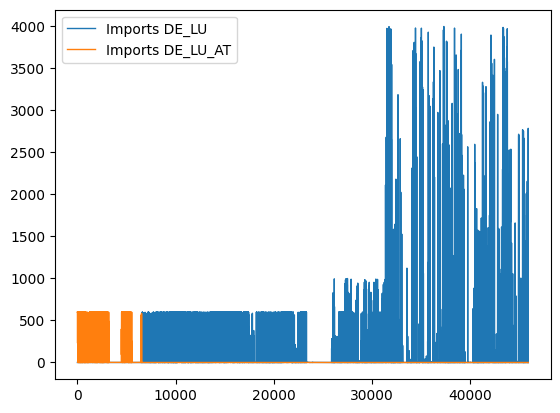

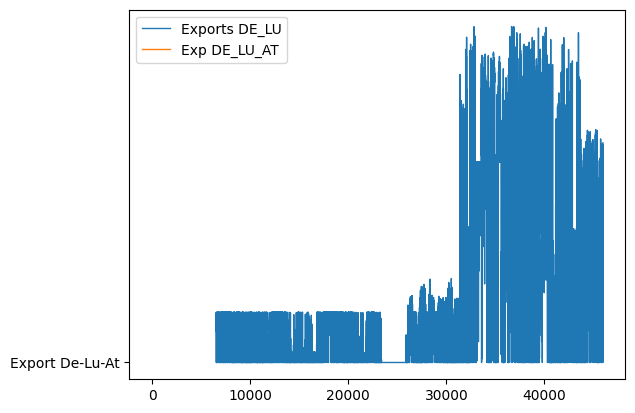

In [4]:
plt.plot(df['DE_LU'], linewidth = 1, label = 'Imports DE_LU')
plt.plot(df['DE_AT_LU'], linewidth = 1, label = 'Imports DE_LU_AT')
plt.legend()
plt.show()
plt.plot(df['Export De-Lu'], linewidth = 1, label = 'Exports DE_LU')
plt.plot(['Export De-Lu-At'], linewidth = 1, label = 'Exp DE_LU_AT')
plt.legend()
plt.show()

In [5]:
cols_na = ['Export De-Lu', 'Export De-Lu-At', 'DE_AT_LU', 'DE_LU']
for col in cols_na:
    df[col].fillna(0, inplace = True)

In [6]:
df['DE_LU_corr'] = df['DE_AT_LU'] + df['DE_LU']
df.drop(['DE_AT_LU', 'DE_LU'], axis = 1, inplace = True)

df['Export DE_LU_corr'] = df['Export De-Lu'] + df['Export De-Lu-At']
df.drop(['Export De-Lu', 'Export De-Lu-At'], axis = 1, inplace = True)

In [7]:
df.isna().sum()

Timestamp                0
Date                     0
TTF                  15672
CO2                  15096
coal                 13440
Day-ahead prices        24
Forecasted Load         25
Actual Load             25
Solar                  313
Wind Offshore          121
Wind Onshore           169
DK_1                    25
SE_4                    25
Export DK1              25
Export SE4              25
DE_LU_corr               0
Export DE_LU_corr        0
dtype: int64

In [8]:
df = get_dt_info(df, 'Timestamp', yr = True, qt = True, mo = True, day = True, date = True, h = True)
df = get_dt_info(df, 'Date', w = True)
df.tail().T

,45979,45980,45981,45982,45983
Timestamp,2023-03-31 19:00:00,2023-03-31 20:00:00,2023-03-31 21:00:00,2023-03-31 22:00:00,2023-03-31 23:00:00
Date,2023-03-31 00:00:00,2023-03-31 00:00:00,2023-03-31 00:00:00,2023-03-31 00:00:00,2023-03-31 00:00:00
TTF,NaN,NaN,NaN,NaN,NaN
CO2,NaN,NaN,NaN,NaN,NaN
coal,177.25,177.25,177.25,177.25,177.25
Day-ahead prices,NaN,NaN,NaN,NaN,NaN
Forecasted Load,NaN,NaN,NaN,NaN,NaN
Actual Load,NaN,NaN,NaN,NaN,NaN
Solar,NaN,NaN,NaN,NaN,NaN
Wind Offshore,NaN,NaN,NaN,NaN,NaN


## Differentiate business and non-business days

In [9]:
# calendar of holidays in DK
dk_bus = pd.tseries.offsets.CustomBusinessDay(calendar = holidays.DK(years = [2018, 2023]))

# range of business days, excluding weekends and holidays
dk_bus_days = pd.bdate_range(min(df['Date']), max(df['Date']), freq = dk_bus)
df['business'] = df['Date'].isin(dk_bus_days)

# Imputation

In [10]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'] == True)]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

TTF 15672 of which 2568 in 107 business days
CO2 15096 of which 1992 in 83 business days
coal 13440 of which 336 in 14 business days
Day-ahead prices 24 of which 24 in 1 business days
Forecasted Load 25 of which 25 in 2 business days
Actual Load 25 of which 25 in 2 business days
Solar 313 of which 215 in 14 business days
Wind Offshore 121 of which 97 in 7 business days
Wind Onshore 169 of which 145 in 10 business days
DK_1 25 of which 25 in 2 business days
SE_4 25 of which 25 in 2 business days
Export DK1 25 of which 25 in 2 business days
Export SE4 25 of which 25 in 2 business days


In [11]:
# in most cases, 'TTF' and 'CO2' NaN are in non-business days, where the price is the same as the last business day --> ffill
for col in ['TTF', 'CO2','coal']:
    df[col].fillna(method = 'ffill', inplace = True)

In [12]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'])]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

TTF 24 of which 24 in 1 business days
CO2 24 of which 24 in 1 business days
coal 24 of which 24 in 1 business days
Day-ahead prices 24 of which 24 in 1 business days
Forecasted Load 25 of which 25 in 2 business days
Actual Load 25 of which 25 in 2 business days
Solar 313 of which 215 in 14 business days
Wind Offshore 121 of which 97 in 7 business days
Wind Onshore 169 of which 145 in 10 business days
DK_1 25 of which 25 in 2 business days
SE_4 25 of which 25 in 2 business days
Export DK1 25 of which 25 in 2 business days
Export SE4 25 of which 25 in 2 business days


In [13]:
idx_drop = []
for col in ['TTF', 'CO2', 'coal','Day-ahead prices']:
    print(col, df[df[col].isna()]['Date'].unique())
    idx_drop.append(df[df[col].isna()]['Date'].unique()[0])

idx_drop = set(idx_drop)

TTF <DatetimeArray>
['2018-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]
CO2 <DatetimeArray>
['2018-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]
coal <DatetimeArray>
['2018-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]
Day-ahead prices <DatetimeArray>
['2023-03-31 00:00:00']
Length: 1, dtype: datetime64[ns]


In [14]:
# some NaNs are in the 1st and last day of the whole dataset, all observations for those days are dropped
df.drop(df[df['Date'].isin(idx_drop)].index, inplace = True)

In [15]:
# check for NaN values
cols_na = []
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        cols_na.append(col)
        b = df[df[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

Forecasted Load 1 
business days 1 <DatetimeArray>
['2023-03-30 00:00:00']
Length: 1, dtype: datetime64[ns]
Actual Load 1 
business days 1 <DatetimeArray>
['2023-03-30 00:00:00']
Length: 1, dtype: datetime64[ns]
Solar 289 
business days 21 <DatetimeArray>
['2020-03-01 00:00:00', '2020-03-02 00:00:00', '2021-10-07 00:00:00',
 '2021-10-08 00:00:00', '2021-10-13 00:00:00', '2021-10-14 00:00:00',
 '2022-04-30 00:00:00', '2022-05-01 00:00:00', '2022-08-13 00:00:00',
 '2022-08-14 00:00:00', '2022-08-16 00:00:00', '2022-08-17 00:00:00',
 '2022-08-31 00:00:00', '2022-09-01 00:00:00', '2022-09-04 00:00:00',
 '2022-09-05 00:00:00', '2022-10-09 00:00:00', '2022-10-10 00:00:00',
 '2022-11-17 00:00:00', '2022-11-26 00:00:00', '2023-03-30 00:00:00']
Length: 21, dtype: datetime64[ns]
Wind Offshore 97 
business days 7 <DatetimeArray>
['2020-03-01 00:00:00', '2020-03-02 00:00:00', '2021-10-07 00:00:00',
 '2021-10-08 00:00:00', '2021-10-13 00:00:00', '2021-10-14 00:00:00',
 '2023-03-30 00:00:00']
Length

In [16]:
cols_na

['Forecasted Load',
 'Actual Load',
 'Solar',
 'Wind Offshore',
 'Wind Onshore',
 'DK_1',
 'SE_4',
 'Export DK1',
 'Export SE4']

In [17]:
df_temp = df.copy()
# df_temp[(df_temp['Hour'] == 17) & ('2020-09-03'< df_temp['Date']) & (df_temp['Date'] <'2020-09-15')]

df_temp.isna().sum()

Timestamp              0
Date                   0
TTF                    0
CO2                    0
coal                   0
Day-ahead prices       0
Forecasted Load        1
Actual Load            1
Solar                289
Wind Offshore         97
Wind Onshore         145
DK_1                   1
SE_4                   1
Export DK1             1
Export SE4             1
DE_LU_corr             0
Export DE_LU_corr      0
Year                   0
Quarter                0
Month                  0
Day                    0
Hour                   0
Week                   0
business               0
dtype: int64

In [18]:
max(df_temp[df_temp['Solar'].isna()]['Date'])

Timestamp('2023-03-30 00:00:00')

In [19]:
# for i in range(24):
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(30, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(24, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(24, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)

In [20]:
d = dict(tuple(df_temp.groupby('Hour')))
df_temp=pd.DataFrame(data=None)
    #split in 24 timestamps/hours
for i in range(24):
    for j in cols_na:
        d[i][j]=d[i][j].fillna(d[i][j].rolling(7,min_periods=1).mean().round(1))
        d[i][j]=d[i][j].fillna(d[i][j].rolling(14,min_periods=1).mean().round(1))
        d[i][j]=d[i][j].fillna(method='pad')
    if i==0:
        df_temp=d[i]
    else:
        df_temp=pd.concat([df_temp,d[i]])
df_temp=df_temp.sort_values('Timestamp')
df_temp.isna().sum()

Timestamp            0
Date                 0
TTF                  0
CO2                  0
coal                 0
Day-ahead prices     0
Forecasted Load      0
Actual Load          0
Solar                0
Wind Offshore        0
Wind Onshore         0
DK_1                 0
SE_4                 0
Export DK1           0
Export SE4           0
DE_LU_corr           0
Export DE_LU_corr    0
Year                 0
Quarter              0
Month                0
Day                  0
Hour                 0
Week                 0
business             0
dtype: int64

In [21]:
# check for NaN values
for col in df_temp.columns:
    a = df_temp[col].isna().sum()
    if a > 0:
        b = df_temp[df_temp[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

In [22]:
df_temp['Wind Total'] = df_temp['Wind Offshore'] + df_temp['Wind Onshore']
df_temp.drop(['Wind Offshore', 'Wind Onshore'], axis = 1, inplace = True)

In [23]:
df_temp.to_csv('./data/DK_2_filled.csv', index = False)

# Lagging

In [24]:
df_lag = pd.DataFrame(df_temp['Day-ahead prices'].copy())
df_lag['DAP-lag24'] = df_lag['Day-ahead prices'].shift(24) # 1 day
df_lag['DAP-lag25'] = df_lag['Day-ahead prices'].shift(25) # 25 h
df_lag['DAP-lag26'] = df_lag['Day-ahead prices'].shift(26) # 26 h
df_lag['DAP-lag27'] = df_lag['Day-ahead prices'].shift(27) # 27 h
df_lag['DAP-lag28'] = df_lag['Day-ahead prices'].shift(28) # 28 h
df_lag['DAP-lag29'] = df_lag['Day-ahead prices'].shift(29) # 29 h
df_lag['DAP-lag30'] = df_lag['Day-ahead prices'].shift(30) # 30 h
df_lag['DAP-lag31'] = df_lag['Day-ahead prices'].shift(31) # 31 h
df_lag['DAP-lag32'] = df_lag['Day-ahead prices'].shift(32) # 32 h
df_lag['DAP-lag33'] = df_lag['Day-ahead prices'].shift(33) # 33 h
df_lag['DAP-lag34'] = df_lag['Day-ahead prices'].shift(34) # 34 h
df_lag['DAP-lag35'] = df_lag['Day-ahead prices'].shift(35) # 35 h
df_lag['DAP-lag36'] = df_lag['Day-ahead prices'].shift(36) # 36 h
df_lag['DAP-lag48'] = df_lag['Day-ahead prices'].shift(24*2) # 2 days
df_lag['DAP-lag72'] = df_lag['Day-ahead prices'].shift(24*3) # 2 days
df_lag['DAP-lag168'] = df_lag['Day-ahead prices'].shift(24*7) # 1 week
df_lag['DAP-lag720'] = df_lag['Day-ahead prices'].shift(24*30) # 1 month
df_lag['DAP-lag2160'] = df_lag['Day-ahead prices'].shift(24*30*3) # 3 months
df_lag['DAP-lag8760'] = df_lag['Day-ahead prices'].shift(24*365) # 1 year
df_lag['DAP-lag-168'] = df_lag['Day-ahead prices'].shift(-24*7) # 1 week ahead

In [25]:
df_lag.head()

,Day-ahead prices,DAP-lag24,DAP-lag25,DAP-lag26,DAP-lag27,DAP-lag28,DAP-lag29,DAP-lag30,DAP-lag31,DAP-lag32,...,DAP-lag34,DAP-lag35,DAP-lag36,DAP-lag48,DAP-lag72,DAP-lag168,DAP-lag720,DAP-lag2160,DAP-lag8760,DAP-lag-168
24,18.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.17
25,14.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.10
26,17.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.79
27,24.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.99
28,17.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.24


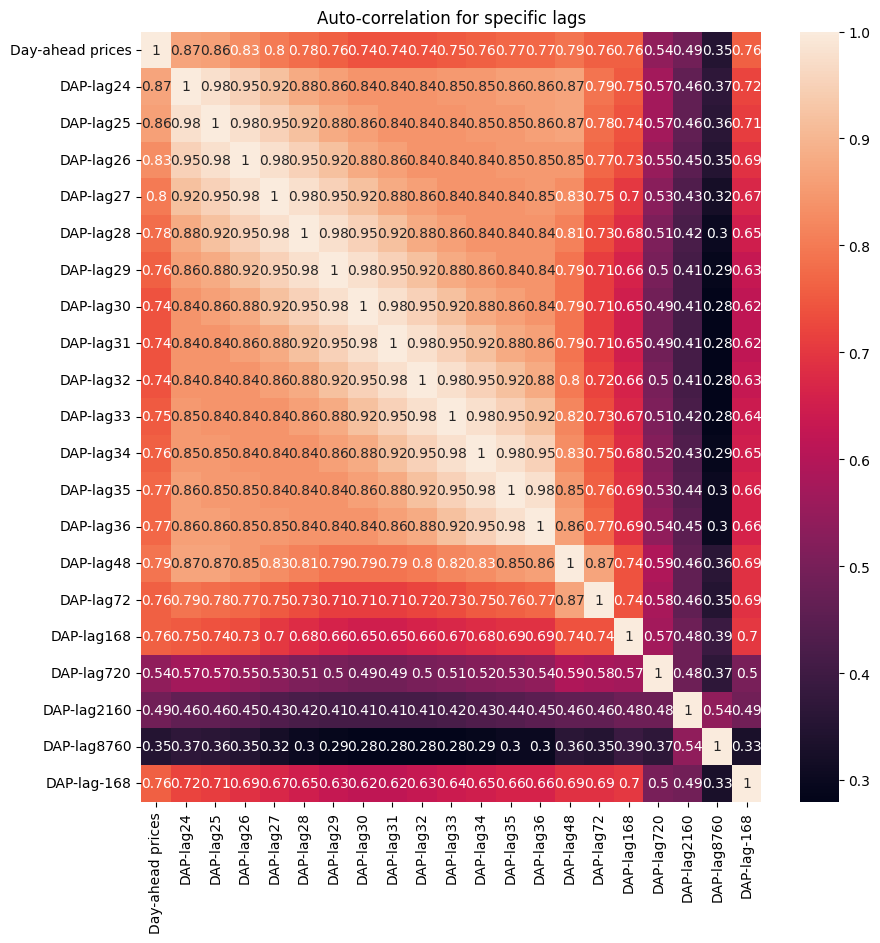

In [26]:
plt.figure(figsize = (10,10))
matrix = df_lag.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [27]:
lags = [24, 36, 48, 72, 168, -168]
lags_names = ['DAP-lag'+str(lag) for lag in lags]

In [28]:
df_lag = df_temp.drop(['Timestamp'], axis =  1)
for lag, name in zip(lags, lags_names):
    df_lag[name] = df_lag['Day-ahead prices'].shift(lag)

In [29]:
matrix = df_lag.corr().round(1)

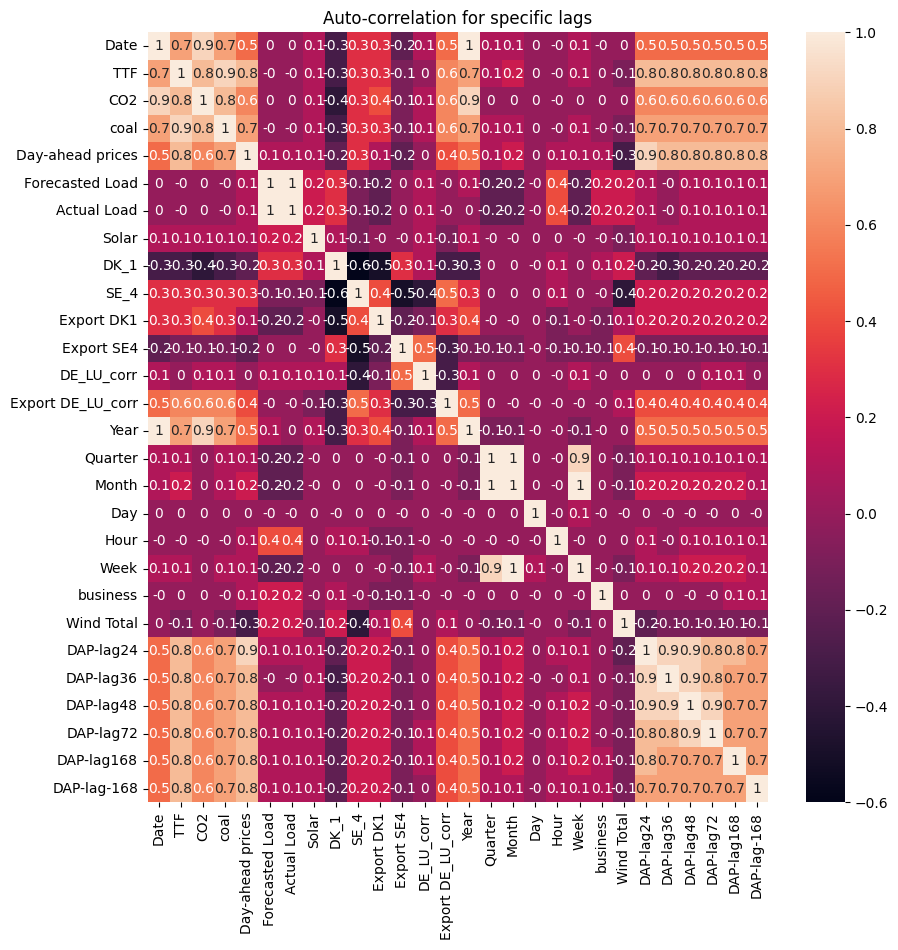

In [30]:
plt.figure(figsize = (10,10))
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [31]:
df_lag.isna().sum()

Date                   0
TTF                    0
CO2                    0
coal                   0
Day-ahead prices       0
Forecasted Load        0
Actual Load            0
Solar                  0
DK_1                   0
SE_4                   0
Export DK1             0
Export SE4             0
DE_LU_corr             0
Export DE_LU_corr      0
Year                   0
Quarter                0
Month                  0
Day                    0
Hour                   0
Week                   0
business               0
Wind Total             0
DAP-lag24             24
DAP-lag36             36
DAP-lag48             48
DAP-lag72             72
DAP-lag168           168
DAP-lag-168          168
dtype: int64

In [32]:
idx_drop = []
for col in lags_names:
    print(col, df_lag[df_lag[col].isna()]['Date'].unique())
    idx_drop=(df_lag[df_lag[col].isna()]['Date'].unique())
    df_lag.drop(df_lag[df_lag['Date'].isin(idx_drop)].index, inplace = True)





DAP-lag24 <DatetimeArray>
['2018-01-02 00:00:00']
Length: 1, dtype: datetime64[ns]
DAP-lag36 <DatetimeArray>
['2018-01-03 00:00:00']
Length: 1, dtype: datetime64[ns]
DAP-lag48 <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
DAP-lag72 <DatetimeArray>
['2018-01-04 00:00:00']
Length: 1, dtype: datetime64[ns]
DAP-lag168 <DatetimeArray>
['2018-01-05 00:00:00', '2018-01-06 00:00:00', '2018-01-07 00:00:00',
 '2018-01-08 00:00:00']
Length: 4, dtype: datetime64[ns]
DAP-lag-168 <DatetimeArray>
['2023-03-24 00:00:00', '2023-03-25 00:00:00', '2023-03-26 00:00:00',
 '2023-03-27 00:00:00', '2023-03-28 00:00:00', '2023-03-29 00:00:00',
 '2023-03-30 00:00:00']
Length: 7, dtype: datetime64[ns]


In [33]:
df_lag.isna().sum()

Date                 0
TTF                  0
CO2                  0
coal                 0
Day-ahead prices     0
Forecasted Load      0
Actual Load          0
Solar                0
DK_1                 0
SE_4                 0
Export DK1           0
Export SE4           0
DE_LU_corr           0
Export DE_LU_corr    0
Year                 0
Quarter              0
Month                0
Day                  0
Hour                 0
Week                 0
business             0
Wind Total           0
DAP-lag24            0
DAP-lag36            0
DAP-lag48            0
DAP-lag72            0
DAP-lag168           0
DAP-lag-168          0
dtype: int64

In [34]:
df_lag.to_csv('./data/DK_2_lagged.csv', index = False)

# PCA

In [35]:
df_lag_nan = df_lag.dropna(how = 'any', axis = 'index')

In [36]:
pca = PCA()
pca.fit(df_lag_nan)
print(pca.explained_variance_ratio_.cumsum())

TypeError: Cannot cast DatetimeArray to dtype float64

## Log transform

$\log$ can't deal with negative values, thus, check how many there are:

In [ ]:
df_temp[df_temp['Day-ahead prices'] < 0].describe()

In [ ]:
plt.plot(df_temp[df_temp['Day-ahead prices'] >= 0]['Day-ahead prices'], label = 'Positive', linewidth = 0, marker = 'o', ms = 0.5)
plt.plot(df_temp[df_temp['Day-ahead prices'] < 0]['Day-ahead prices'], label = 'Negative', linewidth = 0, marker = 'o', ms = 0.5)
plt.title('Day-ahead prices\Time-series')
plt.xlabel('Time')
plt.ylabel('Price\€/MWh')
plt.legend()
plt.show()

In [ ]:
df_temp['Day-ahead prices'].plot.hist(bins = 100)
plt.xlabel('Price\n€/MWh')
plt.title('Day-ahead prices\nHistogram')
plt.show()

In [ ]:
df_log = df_temp[df_temp['Day-ahead prices'] > 0].copy()
df_log['Day-ahead prices log'] = np.log(df_log['Day-ahead prices'])

In [ ]:
df_log['Day-ahead prices log'].plot.hist(bins = 100)
plt.xlabel('Price\n€/MWh')
plt.title('log(Day-ahead prices)\nHistogram')
plt.show()